In [1]:
import sys
import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import sqlalchemy as sq
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix

import tensorflow
from tensorflow import keras
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

import kerastuner as kt
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization

from ann_visualizer.visualize import ann_viz
import graphviz



sys.path.append("../Shared/")
from DataService import DataService

sys.path.append("../Datasets/")
from DataCreation import getDatasetV1, getDatasetV2, getDatasetV3, getDatasetV4



/home/student/dodhiajk/CGC_Grain_Outcome_Predictions/.venv/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/home/student/dodhiajk/CGC_Grain_Outcome_Predictions/.venv/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
/tmp/ipykernel_533640/1624141961.py:10: DeprecationWarning:

In [2]:
tensorflow.config.set_visible_devices([], 'GPU')  # Hide GPU devices
tensorflow.config.set_visible_devices(tensorflow.config.list_physical_devices('CPU'), 'CPU')  # Show CPU devices

2023-07-24 23:44:35.739619: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-07-24 23:44:35.739658: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: woodswallow-02.cs.umanitoba.ca
2023-07-24 23:44:35.739664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: woodswallow-02.cs.umanitoba.ca
2023-07-24 23:44:35.739748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.125.6
2023-07-24 23:44:35.739765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 510.108.3
2023-07-24 23:44:35.739770: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 510.108.3 does not match DSO version 525.125.6 -- cannot find working 

In [3]:
load_dotenv()
PG_DB = os.getenv("POSTGRES_DB")
PG_ADDR = os.getenv("POSTGRES_ADDR")
PG_PORT = os.getenv("POSTGRES_PORT")
PG_USER = os.getenv("POSTGRES_USER")
PG_PW = os.getenv("POSTGRES_PW")

if (
    PG_DB is None
    or PG_ADDR is None
    or PG_PORT is None
    or PG_USER is None
    or PG_PW is None
):
    raise ValueError("Environment variables not set")

# connecting to database
db = DataService(PG_DB, PG_ADDR, int(PG_PORT), PG_USER, PG_PW)
conn = db.connect()

In [28]:
query = sq.text("select * FROM public.dataset_monthly_station_soil_ergot")
test_df = pd.read_sql(query, conn)

In [29]:
test_df.dropna(inplace=True)

In [30]:
test_df.columns

Index(['year', 'district', 'min_temp_x', 'max_temp_x', 'mean_temp_x',
       'min_dew_point_temp', 'max_dew_point_temp', 'mean_dew_point_temp',
       'min_humidex', 'max_humidex', 'mean_humidex', 'min_precip',
       'max_precip', 'mean_precip', 'min_rel_humid', 'max_rel_humid',
       'mean_rel_humid', 'min_stn_press', 'max_stn_press', 'mean_stn_press',
       'min_visibility', 'max_visibility', 'mean_visibility', 'max_temp_y',
       'min_temp_y', 'mean_temp_y', 'min_total_rain', 'max_total_rain',
       'mean_total_rain', 'min_total_snow', 'max_total_snow',
       'mean_total_snow', 'min_total_precip', 'max_total_precip',
       'mean_total_precip', 'min_snow_on_grnd', 'max_snow_on_grnd',
       'mean_snow_on_grnd', 'soil_moisture_min', 'soil_moisture_max',
       'soil_moisture_mean', 'present_prev1', 'present_prev2', 'present_prev3',
       'sum_severity_prev1', 'sum_severity_prev2', 'sum_severity_prev3',
       'percnt_true_prev1', 'percnt_true_prev2', 'percnt_true_prev3',
     

In [31]:
test_df.drop(columns=["incidence", "severity", "severity_bin_quan", "severity_bin_arb", "province"], inplace=True)

In [32]:
test_df

,year,district,min_temp_x,max_temp_x,mean_temp_x,min_dew_point_temp,max_dew_point_temp,mean_dew_point_temp,min_humidex,max_humidex,...,sum_severity_prev3,percnt_true_prev1,percnt_true_prev2,percnt_true_prev3,median_prev1,median_prev2,median_prev3,sample_id,crop_district,downgrade
136630,1998,4810,-31.9,7.6,-8.371284,-35.0,3.9,-11.749697,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,38575.0,1.0,False
136631,1998,4810,-31.9,7.6,-8.371284,-35.0,3.9,-11.749697,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,38646.0,1.0,False
136632,1998,4810,-31.9,7.6,-8.371284,-35.0,3.9,-11.749697,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,38647.0,1.0,False
136633,1998,4810,-31.9,7.6,-8.371284,-35.0,3.9,-11.749697,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,38648.0,1.0,False
136634,1998,4810,-31.9,7.6,-8.371284,-35.0,3.9,-11.749697,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,38649.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518506,2017,4791,-8.7,19.7,4.542888,-10.0,9.3,-0.861760,0.0,0.0,...,0.0,0.205128,0.119048,0.0,0.0,0.0,0.0,133105.0,92.0,False
518507,2017,4791,-8.7,19.7,4.542888,-10.0,9.3,-0.861760,0.0,0.0,...,0.0,0.205128,0.119048,0.0,0.0,0.0,0.0,133191.0,92.0,False
518508,2017,4791,-8.7,19.7,4.542888,-10.0,9.3,-0.861760,0.0,0.0,...,0.0,0.205128,0.119048,0.0,0.0,0.0,0.0,133282.0,92.0,False
518509,2017,4791,-8.7,19.7,4.542888,-10.0,9.3,-0.861760,0.0,0.0,...,0.0,0.205128,0.119048,0.0,0.0,0.0,0.0,133509.0,92.0,False


In [33]:
df= test_df.copy()

In [34]:
TARGET = "downgrade"
df[TARGET] = df[TARGET].astype(int) # 0: Flase, 1: True
t = pd.get_dummies(df["district"], drop_first=True)
df = pd.concat([df, t], axis=1)
df.columns = df.columns.astype(str)
df.drop_duplicates(inplace=True)

In [35]:
df.shape

(324680, 92)

### getting data

In [32]:
months = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]

In [33]:
TARGET = "sellable"

df = getDatasetV4(months)
df[TARGET] = df[TARGET].astype(int) # 0: Flase, 1: True
t = pd.get_dummies(df["district"], drop_first=True)
df = pd.concat([df, t], axis=1)
df.columns = df.columns.astype(str)
df.drop_duplicates(inplace=True)
# df.drop(["severity"], axis=1, inplace=True)
df

,year,district,percnt_true,has_ergot,median_severity,sum_severity,present_in_neighbor,sum_severity_in_neighbor,present_prev1,present_prev2,...,4781,4790,4791,4810,4820,4830,4840,4850,4860,4870
0,1995,4810,0.000000,False,0.0,0.00,False,0.000000,False,False,...,0,0,0,1,0,0,0,0,0,0
232,1995,4820,0.000000,False,0.0,0.00,True,0.005747,False,False,...,0,0,0,0,1,0,0,0,0,0
812,1995,4830,0.010582,True,0.0,11.00,True,0.001817,False,False,...,0,0,0,0,0,1,0,0,0,0
867,1995,4830,0.010582,True,0.0,11.00,True,0.001817,False,False,...,0,0,0,0,0,1,0,0,0,0
1001,1995,4840,0.006017,True,0.0,15.00,False,0.000000,False,False,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153506,2021,4781,0.000000,False,0.0,0.00,True,0.018663,True,True,...,1,0,0,0,0,0,0,0,0,0
153601,2021,4761,0.010204,True,0.0,0.01,True,0.005495,True,True,...,0,0,0,0,0,0,0,0,0,0
153699,2021,4771,0.000000,False,0.0,0.00,True,0.051688,True,True,...,0,0,0,0,0,0,0,0,0,0
153821,2021,4790,0.025316,True,0.0,0.06,True,0.010929,True,True,...,0,1,0,0,0,0,0,0,0,0


In [34]:
df.columns

Index(['year', 'district', 'percnt_true', 'has_ergot', 'median_severity',
       'sum_severity', 'present_in_neighbor', 'sum_severity_in_neighbor',
       'present_prev1', 'present_prev2', 'present_prev3', 'sum_severity_prev1',
       'sum_severity_prev2', 'sum_severity_prev3', 'percnt_true_prev1',
       'percnt_true_prev2', 'percnt_true_prev3', 'median_prev1',
       'median_prev2', 'median_prev3', 'severity_prev1', 'severity_prev2',
       'severity_prev3', 'severity_in_neighbor', 'ergot_present_in_q1',
       'ergot_present_in_q2', 'ergot_present_in_q3', 'ergot_present_in_q4',
       'sum_severity_in_q1', 'sum_severity_in_q2', 'sum_severity_in_q3',
       'sum_severity_in_q4', 'sellable', 'soil_moisture_mean',
       'avg_percnt_coarse_frag', 'avg_total_sand', 'avg_total_silt',
       'avg_total_clay', 'avg_percnt_carbon', 'avg_calcium_ph', 'avg_proj_ph',
       'avg_water_reten_0', 'avg_water_reten_10', 'avg_water_reten_33',
       'avg_water_reten_1500', 'avg_bulk_density', 'avg_

In [35]:
df.drop(columns=["percnt_true", "has_ergot", "median_severity", "sum_severity", "present_in_neighbor", "sum_severity_in_neighbor", "severity_in_neighbor", "ergot_present_in_q1", "ergot_present_in_q2", "ergot_present_in_q3"
                 , "ergot_present_in_q4", "sum_severity_in_q1", "sum_severity_in_q2", "sum_severity_in_q3", "sum_severity_in_q4"], inplace=True)

In [36]:
df.corr()[TARGET]

year            -0.000067
district        -0.041976
present_prev1   -0.085820
present_prev2   -0.061270
present_prev3   -0.059122
                   ...   
4830            -0.025880
4840            -0.074334
4850            -0.053827
4860             0.026020
4870             0.005319
Name: sellable, Length: 78, dtype: float64

In [37]:
# df.drop(["severity"], axis=1, inplace=True)

### splitting data

In [38]:
# split data into train, validate and test
# TARGET = 'has_ergot'
PIVOT = 2019

In [39]:
# split datframe till 2018
df_train = df[df['year'] < PIVOT]
df_train.drop(columns=['year', 'district'], inplace=True)
X_train_df = df_train.drop(columns=[TARGET])
y_train_df = df_train[TARGET]

# X_train_df

/tmp/ipykernel_533640/1330982459.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=['year', 'district'], inplace=True)


In [40]:
#split dataframe from 2019
df_test = df[df['year'] >= PIVOT]
df_test.drop(columns=['year', 'district'], inplace=True)
X_test = df_test.drop(columns=[TARGET])
y_test = df_test[TARGET]

X_test

/tmp/ipykernel_533640/2722088680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=['year', 'district'], inplace=True)


,present_prev1,present_prev2,present_prev3,sum_severity_prev1,sum_severity_prev2,sum_severity_prev3,percnt_true_prev1,percnt_true_prev2,percnt_true_prev3,median_prev1,...,4781,4790,4791,4810,4820,4830,4840,4850,4860,4870
139034,True,True,True,0.092715,0.147287,0.246269,0.092715,0.147287,0.246269,0.0,...,0,0,0,1,0,0,0,0,0,0
139206,True,True,True,0.178723,0.309045,0.289753,0.178723,0.309045,0.289753,0.0,...,0,0,0,0,1,0,0,0,0,0
139266,True,True,True,0.178723,0.309045,0.289753,0.178723,0.309045,0.289753,0.0,...,0,0,0,0,1,0,0,0,0,0
139639,True,True,True,0.192513,0.303191,0.401460,0.192513,0.303191,0.401460,0.0,...,0,0,0,0,0,1,0,0,0,0
139742,True,True,True,0.192513,0.303191,0.401460,0.192513,0.303191,0.401460,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153506,True,True,True,0.151515,0.097778,0.143750,0.151515,0.097778,0.143750,0.0,...,1,0,0,0,0,0,0,0,0,0
153601,True,True,True,0.076923,0.062893,0.161491,0.076923,0.062893,0.161491,0.0,...,0,0,0,0,0,0,0,0,0,0
153699,True,True,True,0.153333,0.013072,0.164179,0.153333,0.013072,0.164179,0.0,...,0,0,0,0,0,0,0,0,0,0
153821,True,True,True,0.229167,0.147727,0.396476,0.229167,0.147727,0.396476,0.0,...,0,1,0,0,0,0,0,0,0,0


In [41]:
# now we treat the train data as a whole and split it into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_df, y_train_df, test_size=0.2, random_state=42)

### scaling and oversampling

In [42]:
# normalizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# oversampling data
ros = RandomOverSampler(random_state=42)
X_train_rs, y_train_rs = ros.fit_resample(X_train, y_train)

### Model

In [43]:
from sklearn import metrics
from keras import backend as K

def auc(y_true, y_pred):
    auc = tensorflow.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tensorflow.local_variables_initializer())
    return auc

In [110]:
def build_model(hp):
    model = Sequential()
    # model.add(Dense(input_dim=X_train.shape[1]))
    for i in range(hp.Int('num_layers', 2, 15)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=748, # 512
                                            step=32),
                                activation=hp.Choice('act_' + str(i), ['relu', 'sigmoid']),# , 'tanh', 'elu', 'selu', 'softplus', 'softsign', 'exponential', 'linear'])))
                                # kernel_regularizer = hp.Choice('kr_'+str(i), ['l2(0.01)', 'l1(0.01)', "l1_l2(0.01)"])))
                                kernel_regularizer = l1_l2(0.01)))
        
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])
    return model

In [111]:
directory_path = 'data/random_search/'

if os.path.exists(directory_path):
    os.removedirs(directory_path)
    

# tuner = RandomSearch(
#     build_model,
#     objective=kt.Objective("val_auc", direction="max"),
#     max_trials=5,
#     executions_per_trial=3,
#     directory='data/random_search',
#     project_name='ergot_random_search')

tuner2 = BayesianOptimization(
    build_model,
    objective=kt.Objective("val_auc", direction="max"),
    max_trials=5,
    executions_per_trial=3,
    directory='data/BayesianOptimization',
    project_name='ergot_random_search')

In [112]:
# tuner.search_space_summary()
tuner2.search_space_summary()


Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 15, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 748, 'step': 32, 'sampling': 'linear'}
act_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 748, 'step': 32, 'sampling': 'linear'}
act_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [113]:
# tuner.search(X_train_rs, y_train_rs, epochs=100, validation_data=(X_val, y_val), batch_size=32)
tuner2.search(X_train_rs, y_train_rs, epochs=100, validation_data=(X_val, y_val))

Trial 5 Complete [00h 01m 38s]
val_auc: 0.5

Best val_auc So Far: 0.5
Total elapsed time: 00h 12m 32s
INFO:tensorflow:Oracle triggered exit


In [106]:
tuner.results_summary()

Results summary
Results in data/random_search/ergot_random_search
Showing 10 best trials
Objective(name="val_auc", direction="max")

Trial 0 summary
Hyperparameters:
num_layers: 10
units_0: 128
act_0: sigmoid
units_1: 352
act_1: sigmoid
learning_rate: 0.0001
units_2: 32
act_2: relu
units_3: 32
act_3: relu
units_4: 32
act_4: relu
units_5: 32
act_5: relu
units_6: 32
act_6: relu
units_7: 32
act_7: relu
units_8: 32
act_8: relu
units_9: 32
act_9: relu
Score: 0.5271786650021871

Trial 1 summary
Hyperparameters:
num_layers: 30
units_0: 544
act_0: relu
units_1: 192
act_1: sigmoid
learning_rate: 0.0001
units_2: 64
act_2: sigmoid
units_3: 480
act_3: relu
units_4: 704
act_4: sigmoid
units_5: 480
act_5: relu
units_6: 384
act_6: sigmoid
units_7: 544
act_7: sigmoid
units_8: 192
act_8: sigmoid
units_9: 416
act_9: sigmoid
units_10: 32
act_10: relu
units_11: 32
act_11: relu
units_12: 32
act_12: relu
units_13: 32
act_13: relu
units_14: 32
act_14: relu
units_15: 32
act_15: relu
units_16: 32
act_16: relu


In [73]:
# model = Sequential()

# model.add(Dense(64, activation='relu' ,input_dim=X_train.shape[1])) #, kernel_regularizer=l2(0.01)
# # model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# # model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# # model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(64, activation='relu'))
# # model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid')) # , kernel_regularizer=l2(0.01)

# model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [108]:
model = tuner.get_best_models(num_models=1)[0]
model.build(X_train.shape)

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for data/random_search/ergot_random_search/trial_0/checkpoint

In [ ]:
from keras.activations import relu, sigmoid

model = Sequential()
model.add(Dense(448, activation='sigmoid' ,input_dim=X_train.shape[1]))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()
model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1030, 128)               9728      
                                                                 
 dense_1 (Dense)             (1030, 480)               61920     
                                                                 
 dense_2 (Dense)             (1030, 160)               76960     
                                                                 
 dense_3 (Dense)             (1030, 192)               30912     
                                                                 
 dense_4 (Dense)             (1030, 128)               24704     
                                                                 
 dense_5 (Dense)             (1030, 96)                12384     
                                                                 
 dense_6 (Dense)             (1030, 320)               3

In [76]:
# ann_viz(model, title="Ergot Model")
# graph_file = graphviz.Source.from_file('network.gv')


In [77]:
# graph_file

In [78]:
# history = model.fit(X_train_rs, y_train_rs, epochs=500, batch_size=64, validation_data=(X_val, y_val), verbose=1)
history = model.fit(X_train_rs, y_train_rs, epochs=500, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/500


18/18 [==============================] - 1s 12ms/step - loss: 0.6545 - accuracy: 0.6250 - auc: 0.5750 - val_loss: 0.9881 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/500
18/18 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.6083 - auc: 0.6041 - val_loss: 0.9044 - val_accuracy: 0.3521 - val_auc: 0.0000e+00
Epoch 3/500
18/18 [==============================] - 0s 4ms/step - loss: 0.6317 - accuracy: 0.6083 - auc: 0.6370 - val_loss: 0.9834 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 4/500
18/18 [==============================] - 0s 4ms/step - loss: 0.6236 - accuracy: 0.6127 - auc: 0.6478 - val_loss: 1.0014 - val_accuracy: 0.0070 - val_auc: 0.0000e+00
Epoch 5/500
18/18 [==============================] - 0s 4ms/step - loss: 0.6191 - accuracy: 0.6153 - auc: 0.6582 - val_loss: 0.9701 - val_accuracy: 0.2007 - val_auc: 0.0000e+00
Epoch 6/500
18/18 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6285 - auc: 0.6517 - val

In [79]:
def evaluate_model(history):
    # Get the training and validation loss from the history
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Get the training and validation accuracy from the history
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Plot the training and validation loss
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

    # Check if the model is overfitting, underfitting, or performing well
    # final_training_loss = np.array(training_loss).mean()
    # final_validation_loss = np.array(validation_loss).mean()

    # final_training_accuracy = np.array(training_accuracy).mean()
    # final_validation_accuracy = np.array(validation_accuracy).mean()

    # if final_training_loss < final_validation_loss:
    #     print("The model is likely underfitting.")
    # elif final_training_loss > final_validation_loss:
    #     print("The model is likely overfitting.")
    # else:
    #     print("The model is performing well and generalizing to new data.")

    # if final_training_accuracy == 1.0 and final_validation_accuracy == 1.0:
    #     print("The model has achieved 100% accuracy on both training and validation data.")

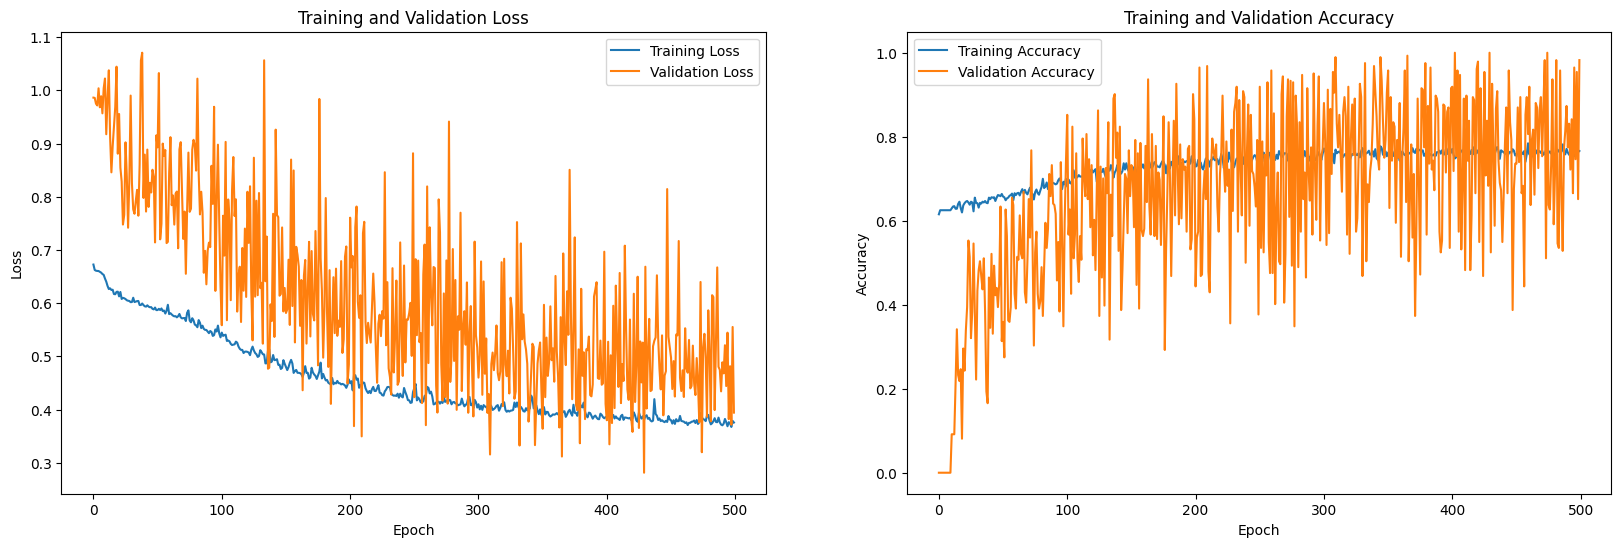

In [60]:
evaluate_model(history)

In [34]:
model.save('data/ergot_model.h5')

###  pred

In [ ]:
y_log = model.predict(X_val)
y_pred = np.where(y_log > 0.5, 1, 0)

9/9 [==============================] - 0s 1ms/step


In [ ]:
conf_matrix = confusion_matrix(y_val, y_pred)

accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
print("Accuracy: ", accuracy)

precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
print("Precision: ", precision)

recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print("Recall: ", recall)

f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score: ", f1_score)

auc_score = roc_auc_score(y_val, y_pred)
print("AUC Score: ", auc_score)

# print(classification_report(y_val, y_pred))

Accuracy:  0.6937984496124031
Precision:  0.6937984496124031
Recall:  1.0
F1 Score:  0.8192219679633868
AUC Score:  0.5


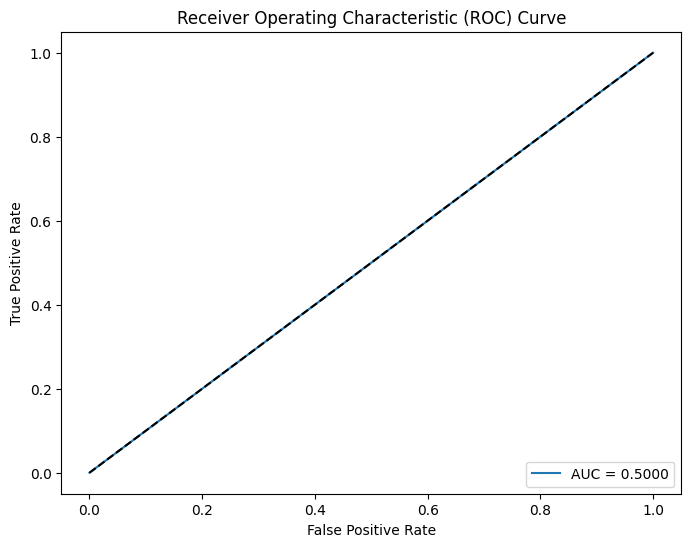

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# d1
[64, 16, 8, 4, 1]
- Accuracy:  0.7759562841530054
- Precision:  0.8767123287671232
- Recall:  0.847682119205298
- F1 Score:  0.861952861952862
- AUC Score:  0.642591059602649

[48, 48, 48, 48, 1]
- Accuracy:  0.7978142076502732
- Precision:  0.9014084507042254
- Recall:  0.847682119205298
- F1 Score:  0.8737201365187712
- AUC Score:  0.705091059602649

In [ ]:
# main prediction

y_main_log = model.predict(X_test)
y_main_pred = np.where(y_main_log > 0.5, 1, 0)

conf_matrix = confusion_matrix(y_test, y_main_pred)

accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
print("Accuracy: ", accuracy)

precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
print("Precision: ", precision)

recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print("Recall: ", recall)

f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score: ", f1_score)

auc_score = roc_auc_score(y_test, y_main_pred)
print("AUC Score: ", auc_score)

# print(classification_report(y_test, y_main_pred))

5/5 [==============================] - 0s 948us/step
Accuracy:  0.5945945945945946
Precision:  0.7906976744186046
Recall:  0.6181818181818182
F1 Score:  0.693877551020408
AUC Score:  0.5722488038277512


### get weights

In [ ]:
def plot_feature_importance(model, feature_names):
    # Get the weights of the first hidden layer
    first_hidden_layer_weights = model.layers[0].get_weights()[0]
    
    # Calculate the mean absolute weight for each feature
    feature_importance = np.mean(np.abs(first_hidden_layer_weights), axis=1)
    
    # Sort the features based on their importance
    sorted_indices = np.argsort(feature_importance)[::-1]
    sorted_feature_importance = feature_importance[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]
    
    # Plot the feature importance
    plt.figure(figsize=(20, 6))
    plt.bar(range(len(feature_names)), sorted_feature_importance)
    plt.xticks(range(len(feature_names)), sorted_feature_names, rotation=45, ha='right')
    plt.xlabel('Feature')
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance of MLP')
    plt.tight_layout()
    plt.show()


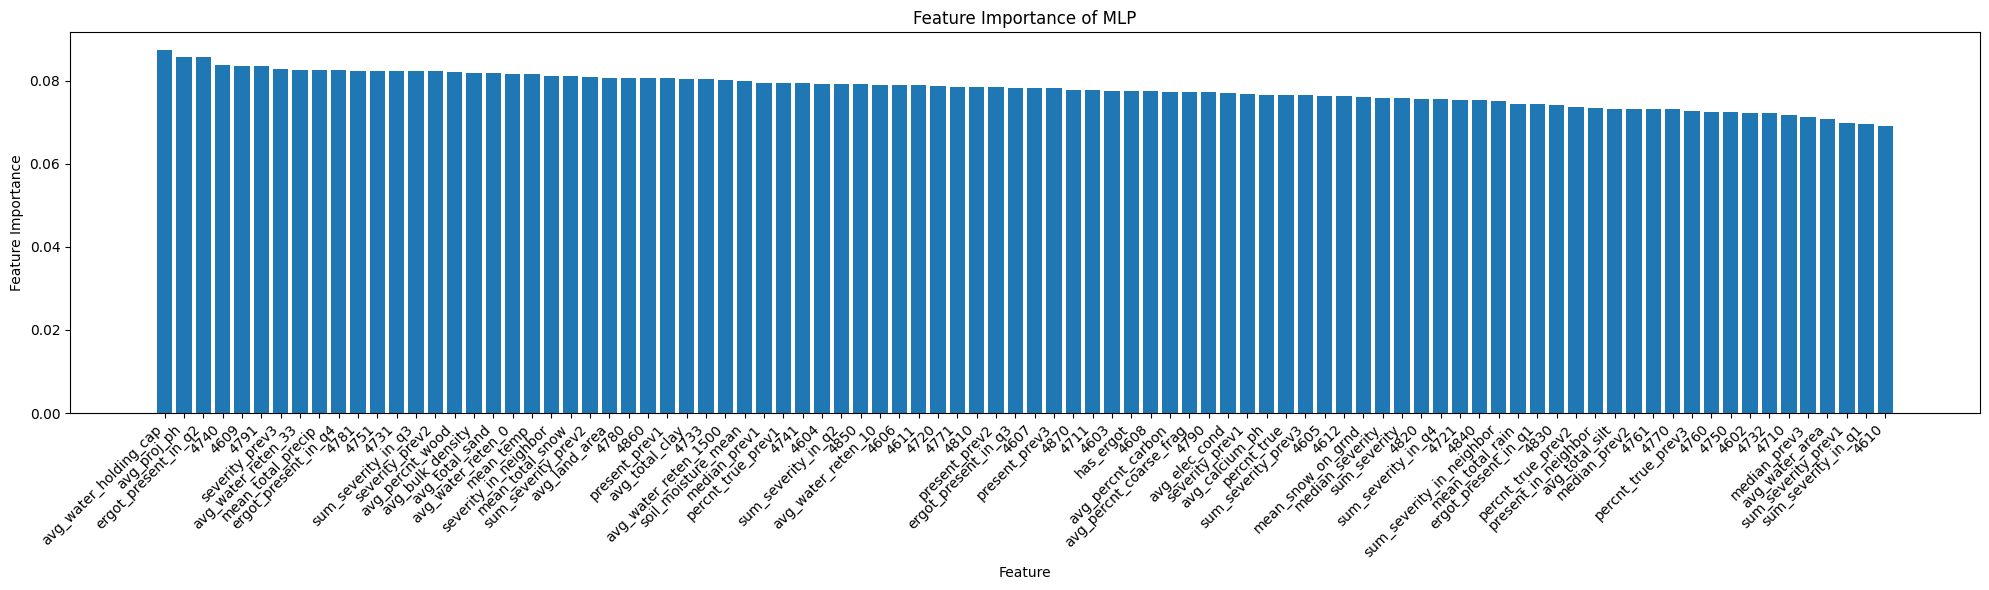

In [ ]:
plot_feature_importance(model, X_train_df.columns)